In [1]:
import pandas as pd
import jax
import jax.numpy as jnp
from typing import Sequence, Tuple
from flax import linen # built on top of jax which creates nn
import optax # library to get optimizer for nn
from sklearn import datasets # provides ml personality
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns # enables you to statistically visualize data

In [2]:
key = jax.random.PRNGKey(42)

In [3]:
seeds = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv', header = None)
seeds

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [6]:
seeds.info() # show all columns of data are floats except target (int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       210 non-null    float64
 1   1       210 non-null    float64
 2   2       210 non-null    float64
 3   3       210 non-null    float64
 4   4       210 non-null    float64
 5   5       210 non-null    float64
 6   6       210 non-null    float64
 7   7       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB


In [8]:
seeds[7].unique() # unique values are 1,2,3

array([1, 2, 3])

In [11]:
X = seeds.iloc[:,0:7] # all rows and columns except for last one
X

,0,1,2,3,4,5,6
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175
...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044


In [10]:
y = seeds.iloc[:,-1]
y

,7
0,1
1,1
2,1
3,1
4,1
...,...
205,3
206,3
207,3
208,3


In [12]:
y.value_counts()

,count
7,
1,70
2,70
3,70


In [14]:
samples, features = X.shape

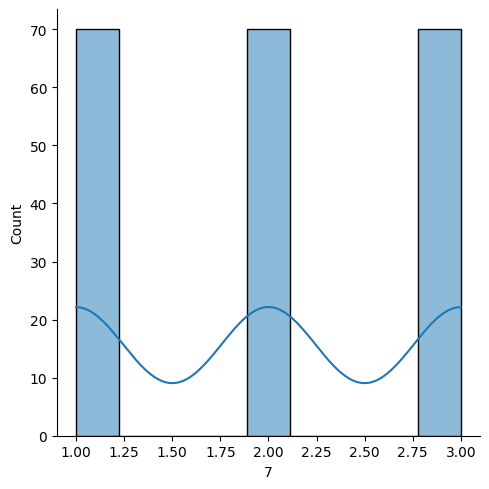

In [15]:
sns.displot(y, kde = True) # 3 classes, each with 70 samples

<Axes: >

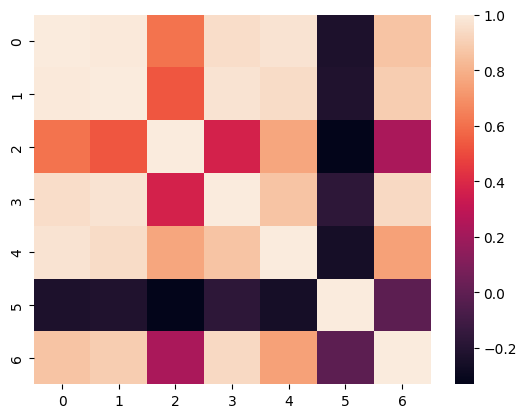

In [16]:
corr = X.corr()
sns.heatmap(corr) # will see that many columns of data are highly correlated

In [17]:
# convert arrays to jax array
# jax model will not work unless arrays are jax arrays
X = jnp.array(X)
y = jnp.array(y)

In [21]:
# standardize data
mean_X = X.mean()
std_dev = jnp.std(X)

X = (X - mean_X) / std_dev

In [23]:
# use sklearn to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(168, 7) (42, 7) (168,) (42,)


In [27]:
# convert labels to one hot encoding
classes = len(jnp.unique(y_train))
y_train_one_hot = jnp.eye(classes)[y_train - 1]
print(y_train_one_hot)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0.

In [28]:
# Flax MLPClassifier
class MultiLayerPerceptronClassifier(linen.Module):
  features: Sequence[int] = (5, 10, 15, classes)

  def setup(self):
    self.layers = [linen.Dense(feat) for feat in self.features]

  def __call__(self, inputs):
    x = inputs
    for i, lyr in enumerate(self.layers):
      x = lyr(x)
      if i != len(self.layers) - 1:
        x = linen.relu(x)
    return linen.softmax(x)

model = MultiLayerPerceptronClassifier()
params = model.init(key, X_train[:5])

for layer_params in params["params"].items():
  print("Layer Name : {}".format(layer_params[0]))
  weights, biases = layer_params[1]["kernel"], layer_params[1]["bias"]

  # layer weights: columns of data in x variable
  # biases: ex, 5 is first number in tuple established in features
  print("\tLayer Weights : {}, Biases : {}".format(weights.shape, biases.shape))

Layer Name : layers_0
	Layer Weights : (7, 5), Biases : (5,)
Layer Name : layers_1
	Layer Weights : (5, 10), Biases : (10,)
Layer Name : layers_2
	Layer Weights : (10, 15), Biases : (15,)
Layer Name : layers_3
	Layer Weights : (15, 3), Biases : (3,)


In [29]:
preds = model.apply(params, X_train[:5]) # for first 5 rows of data
preds # prediction with 3 columns of data

Array([[0.48841223, 0.2437365 , 0.2678513 ],
       [0.6121056 , 0.20383912, 0.18405525],
       [0.5079331 , 0.23251814, 0.25954875],
       [0.5120815 , 0.24804999, 0.2398685 ],
       [0.4569414 , 0.26729435, 0.27576423]], dtype=float32)

In [30]:
def NegLogLoss(weights, input_data, actual):
  preds = model.apply(weights, input_data)
  preds = preds.squeeze()

  # return the formula that use for softmax
  return (- actual * jnp.log(preds) - (1 - actual) * jnp.log(1 - preds)).mean()

In [33]:
epochs = 1000

model = MultiLayerPerceptronClassifier() # define model
random_arr = jax.random.normal(key = key, shape=(5, features)) # array is 5 rows of data by 7 features
params = model.init(key, random_arr) # initialize model parameters

optimizer = optax.sgd(learning_rate = 0.01) # stochastic gradient descent

optimizer_state = optimizer.init(params)
loss_grad = jax.value_and_grad(NegLogLoss) # calculates loss

# train data
for i in range(1, epochs + 1):
  loss_val, gradients = loss_grad(params, X_train, y_train_one_hot)
  updates, optimizer_state = optimizer.update(gradients, optimizer_state)
  params = optax.apply_updates(params, updates)
  if i % 100 == 0:
    print('NegLogLoss After {} Epochs : {:.2f}'.format(i,loss_val))

NegLogLoss After 100 Epochs : 0.61
NegLogLoss After 200 Epochs : 0.59
NegLogLoss After 300 Epochs : 0.57
NegLogLoss After 400 Epochs : 0.54
NegLogLoss After 500 Epochs : 0.51
NegLogLoss After 600 Epochs : 0.47
NegLogLoss After 700 Epochs : 0.42
NegLogLoss After 800 Epochs : 0.38
NegLogLoss After 900 Epochs : 0.34
NegLogLoss After 1000 Epochs : 0.30


In [34]:
test_preds = model.apply(params, X_test) # make prediction on test dataset

test_preds = jnp.argmax(test_preds, axis = 1) # columns
test_preds = test_preds + 1
test_preds[:5], y_test[:5]

(Array([1, 3, 2, 1, 3], dtype=int32), Array([1, 3, 2, 3, 1], dtype=int32))

In [35]:
# accuracy
print("Test Accuracy : {:.2f}".format(accuracy_score(y_test, test_preds)))

Test Accuracy : 0.86


In [36]:
# classification report
print("Test Data Classification Report: ")
print(classification_report(y_test, test_preds))

Test Data Classification Report: 
              precision    recall  f1-score   support

           1       0.78      0.64      0.70        11
           2       0.87      0.93      0.90        14
           3       0.89      0.94      0.91        17

    accuracy                           0.86        42
   macro avg       0.84      0.84      0.84        42
weighted avg       0.85      0.86      0.85        42



In [37]:
# compare nn with sklearn
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state = 42, max_iter = 1000).fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([1, 3, 2, 1, 3, 3, 1, 3, 1, 3, 2, 3, 3, 2, 1, 2, 3, 1, 3, 2, 2, 1,
       3, 2, 2, 3, 1, 2, 1, 3, 3, 3, 2, 1, 2, 2, 3, 2, 2, 3, 1, 3],
      dtype=int32)

In [38]:
acc = accuracy_score(y_test, y_pred)
acc

0.9047619047619048